In [1]:
from collections import OrderedDict
from best.hVI_fsrm import SPaths
from best.hVI_fsrm import spec_Spaths
from best.hVI_models import State_Space, Det_SI_Model
from best.hVI_types import Env, Gamma
import best.rss18_functions as rf
from best.hVI_config import sc, load, parr, obs_action, epsilon, rand_seed
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import copy
import cPickle as pkl
import random
from os import fork
from joblib import Parallel, delayed
import multiprocessing
from itertools import product
import time

from polytope import *
%matplotlib inline

No handlers could be found for logger "polytope.solvers"


In [2]:
import sys
sys.version[0]

'2'

In [3]:
print "Setting Up Scenario"

# Define Regions
# Regs have the same format as RSS code. Regs that are added first have a higher priority
#### Wall region
print("Started wall case")
regs = OrderedDict()
p1 = rf.vertex_to_poly(np.array([[2, 0], [3, 0], [3, 1], [2, 1]]))
regs['r1'] = (p1, 1, 'obs')
p2 = rf.vertex_to_poly(np.array([[2, 1], [3, 1], [3, 2], [2, 2]]))
regs['r2'] = (p2, 1, 'obs')
p3 = rf.vertex_to_poly(np.array([[2, 2], [3, 2], [3, 3], [2, 3]]))
regs['r3'] = (p3, 1, 'obs')
p4 = rf.vertex_to_poly(np.array([[2, 3], [3, 3], [3, 4], [2, 4]]))
regs['r4'] = (p4, .5, 'obs', 1)
p5 = rf.vertex_to_poly(np.array([[2, 4], [3, 4], [3, 5], [2, 5]]))
regs['r5'] = (p5, .3, 'obs', 1)

p1 = rf.vertex_to_poly(np.array([[2, 0], [3, 0], [3, -1], [2, -1]]))
regs['r6'] = (p1, 1, 'obs')
p2 = rf.vertex_to_poly(np.array([[2, -1], [3, -1], [3, -2], [2, -2]]))
regs['r7'] = (p2, 1, 'obs')
p3 = rf.vertex_to_poly(np.array([[2, -2], [3, -2], [3, -3], [2, -3]]))
regs['r8'] = (p3, 1, 'obs')
p4 = rf.vertex_to_poly(np.array([[2, -3], [3, -3], [3, -4], [2, -4]]))
regs['r9'] = (p4, .2, 'obs', 0)
p5 = rf.vertex_to_poly(np.array([[2, -4], [3, -4], [3, -5], [2, -5]]))
regs['r10'] = (p5, .2, 'obs', 0)

a1 = rf.vertex_to_poly(np.array([[4, 0], [5, 0], [5, 1], [4, 1]]))
regs['a1'] = (a1, 0.9, 'sample1', 1)

a2 = rf.vertex_to_poly(np.array([[4, -3], [5, -3], [5, -2], [4, -2]]))
regs['a2'] = (a2, 0.9, 'sample2', 1)

output_color = {'r1': 'red', 'r2': 'red', 'r3': 'red', 'r4': 'red', 'r5': 'red', 'r6': 'red', 'r7': 'red',
                'r8': 'red', 'r9': 'red', 'r10': 'red',
                'a1': 'green','a2': 'blue', 'null': 'white'}
# Define Null regions with bounds of the space for null output with lowest priority
p = rf.vertex_to_poly(np.array([[-3, -5], [-3, 5], [5, -5], [5, 5]]))
regs['null'] = (p, 1.0, 'null')

# Construct belief-MDP for env
env = Env(regs)
print(env)

Setting Up Scenario
Started wall case
Regions: 
OrderedDict([('r4', 0), ('r5', 1), ('r9', 2), ('r10', 3), ('a1', 4), ('a2', 5)])

Total number of unknown regions: 6
Total number of  regions: 13


 Setup Motion and Observation Models 
 The used model contains an integrator for each dimension:

[[1. 0.]
 [0. 1.]]
 Constructing FIRM
[[1. 0.]
 [0. 1.]]
[[0.1 0. ]
 [0.  0.1]]
[[10.51249  0.     ]
 [ 0.      10.51249]]
('remove edge', set([4, 5]))
set(['r4', 'r5', 'null'])
('remove edge', set([4, 38]))
set(['r4', 'null', 'r3'])
('remove edge', set([30, 6]))
set(['null', 'r10'])
('remove edge', set([9, 10]))
set(['null', 'r9', 'r10'])
('remove edge', set([9, 12]))
set(['null', 'r9', 'a2'])
('remove edge', set([9, 30]))
set(['null', 'r9', 'r10'])
('remove edge', set([10, 12]))
set(['a2', 'null', 'r9', 'r10'])
('remove edge', set([36, 38]))
set(['null', 'r1'])
[0.0435  0.87279]
0.053549


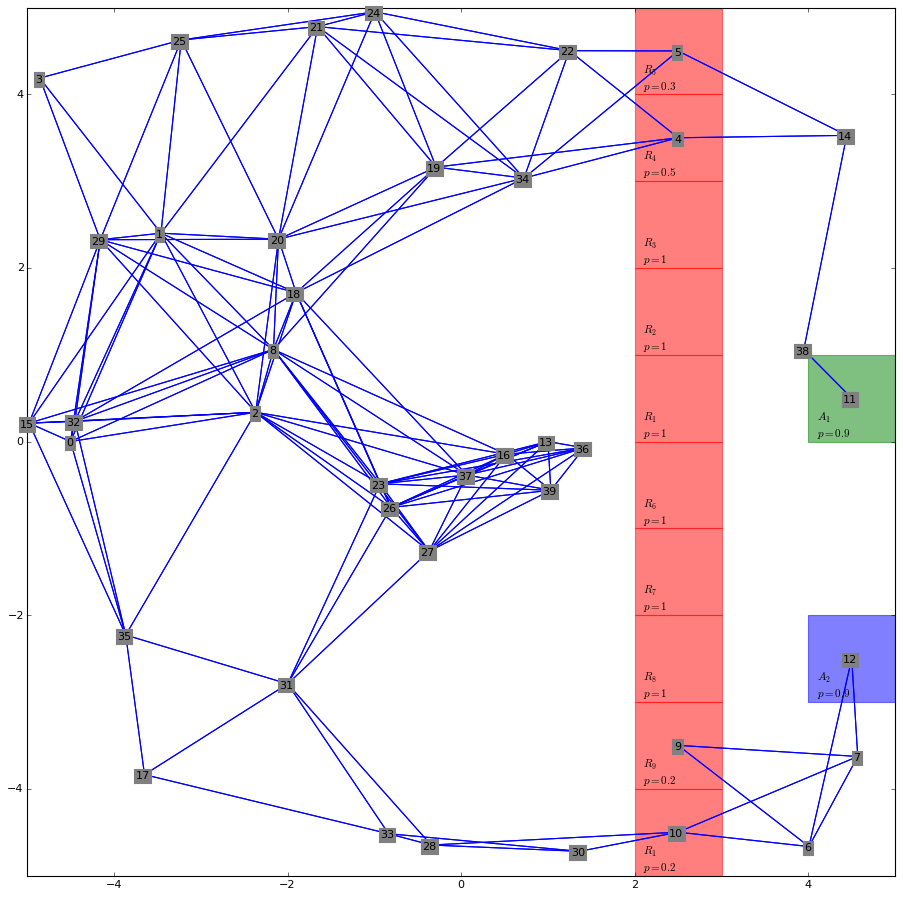

In [4]:
''' Configuration Parameters '''
random.seed(rand_seed)
np.random.seed(rand_seed)

print ''' Setup Motion and Observation Models '''
# Define Motion and Observation Model
Wx = np.eye(2)
Wu = np.eye(2)
r2_bs = State_Space([-5, -5], [5, 5])
motion_model = Det_SI_Model(0.1)

print " Constructing FIRM"
fig = plt.figure(figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, aspect='equal')
firm = SPaths(r2_bs, motion_model, Wx, Wu, regs, output_color, ax)
firm.make_nodes_edges(40, 3, init=np.array([[-4.5],[0]]))
t1 = time.clock()
firm.compute_output_prob()
t2 = time.clock()
firm.plot(ax)
# plt.show()

print(t2-t1)


In [5]:
print('-- Generate the DFA and the Product model c')
from best.fsa import Fsa
props = ['obs', 'sample1', 'sample2']
props = dict(zip(props, map(lambda x: 2 ** x, range(0, len(props)))))
print(props)
fsa = Fsa()
vars(Fsa)
fsa.g.add_node('0')
fsa.g.add_node('trap')
fsa.g.add_node('1')

fsa.g.add_edge('0','1', weight=0, input={props['sample1'],props['sample2'],props['sample2']+props['sample1']})
fsa.g.add_edge('0','0', weight=0, input={0})


fsa.g.add_edge('0','trap', weight=0, input={props['obs']})

fsa.props=props
fsa.final = {'1'}
fsa.init = dict({'0':1})

#fsa.g.add_edge(src, dest, weight=0, input=bitmaps, guard=guard, label=guard)
from best.ltl import formula_to_mdp

fsaform = Fsa()
form = '! obst U sample1'
fsaform.from_formula(form)
vars(fsa.g)
print(fsaform.g.edges(data=True))
formula_fsa = dict()
formula_fsa['fsa'] = fsa
formula_fsa['init'] = dict({'0':1})
formula_fsa['final'] = {'1'}
formula_fsa['prop'] = props

env.get_prop('r3')
prod_ =spec_Spaths(firm, formula_fsa,env)


-- Generate the DFA and the Product model c
{'sample1': 2, 'obs': 1, 'sample2': 4}
[(u'1', u'1', {'input': set([0, 1, 2, 3]), 'guard': '(1)', 'weight': 0, 'label': '(1)'}), (u'0', u'1', {'input': set([2, 3]), 'guard': u'sample1', 'weight': 0, 'label': u'sample1'}), (u'0', u'0', {'input': set([0]), 'guard': u'(!sample1 & !obst)', 'weight': 0, 'label': u'(!sample1 & !obst)'})]
Added virtual final node = (-1, -1)
add edge
add edge
add edge
add edge
add edge
add edge
add edge
add edge
add edge
adding edge to target
add edge
add edge
add edge
adding edge to target
add edge
add edge
add edge
add edge
('visited', [(-1, -1), ('1', 11), ('1', 12), ('0', 38), ('0', 6), ('0', 7), ('0', 11), ('0', 14), ('0', 10), ('0', 9), ('0', 12), ('0', 5), ('0', 4), ('0', 30), ('0', 28), ('0', 34), ('0', 22), ('0', 19), ('0', 33), ('0', 31), ('0', 18), ('0', 21), ('0', 24), ('0', 20), ('0', 8), ('0', 17), ('0', 26), ('0', 23), ('0', 35), ('0', 27), ('0', 2), ('0', 37), ('0', 32), ('0', 1), ('0', 29), ('0', 25)

In [6]:
fsa.next_states_of_fsa('0',{0})

['0']

In [7]:
diff = prod_.sequence
print(prod_.sequence, len(prod_.sequence))

(OrderedDict([((-1, -1), False), (('1', 11), False), (('1', 12), False), (('0', 38), True), (('0', 6), True), (('0', 7), True), (('0', 11), True), (('0', 14), True), (('0', 10), True), (('0', 9), True), (('0', 12), True), (('0', 5), True), (('0', 4), True), (('0', 30), True), (('0', 28), True), (('0', 34), True), (('0', 22), True), (('0', 19), True), (('0', 33), True), (('0', 31), True), (('0', 18), True), (('0', 21), True), (('0', 24), True), (('0', 20), True), (('0', 8), True), (('0', 17), True), (('0', 26), True), (('0', 23), True), (('0', 35), True), (('0', 27), True), (('0', 2), True), (('0', 37), True), (('0', 32), True), (('0', 1), True), (('0', 29), True), (('0', 25), True), (('0', 0), True), (('0', 16), True), (('0', 15), True), (('0', 13), True), (('0', 36), True), (('0', 39), True), (('0', 3), True)]), 43)


In [8]:
print('Start Back-ups')

not_converged = True
i = 1
while not_converged:
    print('iteration', i)
    not_converged = prod_.full_back_up()
    i += 1

Start Back-ups
('iteration', 1)
Do full back-up
2.97916
('iteration', 2)
Do full back-up
3.090761
('iteration', 3)
Do full back-up
2.478691
('iteration', 4)
Do full back-up
2.661881
('iteration', 5)
Do full back-up
3.139741
('iteration', 6)
Do full back-up
3.380967
('iteration', 7)
Do full back-up
3.441658
('iteration', 8)
Do full back-up
3.442509
('iteration', 9)
Do full back-up
3.473959
('iteration', 10)
Do full back-up
3.519927
('iteration', 11)
Do full back-up
3.546709
('iteration', 12)
Do full back-up
4.459875
('iteration', 13)
Do full back-up
4.34492
('iteration', 14)
Do full back-up
3.770579
('iteration', 15)
Do full back-up
4.584675
('iteration', 16)
Do full back-up
3.855556
('iteration', 17)
Do full back-up
3.61897
('iteration', 18)
Do full back-up
3.597799
('iteration', 19)
Do full back-up
3.581179
('iteration', 20)
Do full back-up
3.574149
('iteration', 21)
Do full back-up
3.586524
('iteration', 22)
Do full back-up
3.588306
('iteration', 23)
Do full back-up
3.582904
('iterat

KeyboardInterrupt: 

In [9]:
for region, el in prod_.env.reg_index.items():
    print("{r} has probability  {p}".format(p= prod_.env.b_reg_init[el].tolist()[0][0], r=region ))

r4 has probability  0.5
r5 has probability  0.3
r9 has probability  0.2
r10 has probability  0.2
a1 has probability  0.9
a2 has probability  0.9


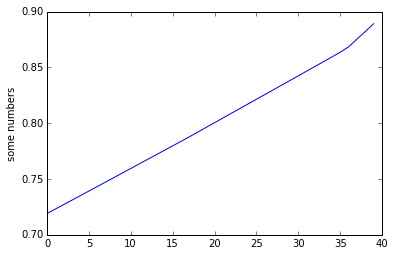

In [14]:
(q,key) = prod_.fsa.init.items()[0]
(q,v) = (q,2)
i = 5
vals = []
for b_i in np.linspace(0,1,40):
    b_ind = [ prob if not el == i else [b_i]  for el,prob in enumerate(prod_.env.b_reg_init.tolist()) ]
    b = prod_.env.get_product_belief(b_ind)
    vals += [max(prod_.val[(q,v)].alpha_mat.T * b).tolist()]
    
import matplotlib.pyplot as plt
plt.plot(sum(vals,[]))
plt.ylabel('some numbers')
plt.show()